# Common Chemical Fragments 1: building the dataset

**Note** this is an extensively revised and updated version of an [older post](https://rdkit.blogspot.com/2016/04/common-chemical-words-1.html).


I got a copy of [Thing Explainer](http://www.amazon.com/Thing-Explainer-Complicated-Stuff-Simple/dp/0544668251) a while ago and I think it's pure genius (not that surprising from Randall Munroe). With my thinking infected by reading the book, the other day I wondered what the ten hundred most common "chemical words" are.

After a bit of extremely deep thinking I decided that I would be willing to accept that a "chemical word" is the kind of fragment that comes out of something like BRICS (or RECAP) decomposition of a molecule.

This post takes that simple idea and applies it to a big database of molecules: the almost 120 million molecules that are in [PubChem Compound](https://pubchem.ncbi.nlm.nih.gov/docs/compounds)

In [1]:
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
from matplotlib import pyplot as plt
%matplotlib inline
print(rdkit.__version__)
import os,time,glob
print( time.asctime())

2025.03.2
Fri May  9 10:59:06 2025


# Background on BRICS

Before diving into the analysis, a bit of explanation about BRICS.

Let's start with the reference:
Degen, J., Wegscheid-Gerlach, C., Zaliani, A. & Rarey, M. "On the Art of Compiling and Using ‘Drug-Like’ Chemical Fragment Spaces". *ChemMedChem* **3**:1503–07 (2008).

The idea is to fragment molecules based on synthetically accessible bonds. Here's an example starting from a random ZINC molecule, ZINC00002139:

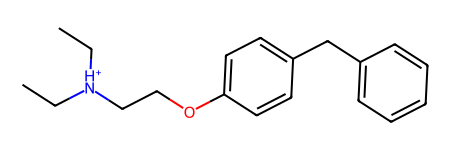

In [2]:
m = Chem.MolFromSmiles('CC[NH+](CC)CCOc1ccc(cc1)Cc2ccccc2')
m

And here are the fragments from doing a BRICS analysis:

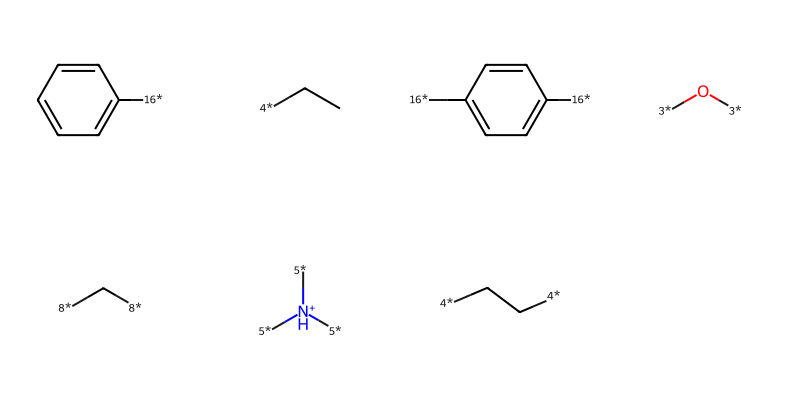

In [3]:
pieces = [Chem.MolFromSmiles(x) for x in BRICS.BRICSDecompose(m)]
Draw.MolsToGridImage(pieces,molsPerRow=4)

The isotope labels on the molecules provide information about the type of bond that was broken and can be used later (using `BRICS.BRICSBuild()`) to build new molecules. For example, the rules allow a bond to be formed between an atom connected to a `[4*]` and an atom connected to a `[5*]`.

One important characteristic (I hesitate to use "feature" in this context) of the current RDKit BRICS implementation that impacts this analysis is that only unique fragments are returned. So we only get one `[4*]CC` fragment for that molecule above, even though it appears in the molecule twice.

So the analysis below is of the most common chemical words, but we only count frequency based on the number of molecules they appear in, not *how often* they appear in those molecules.

# The computation

Dealing with 120 million molecules takes a long time, so I ran this on the compute cluster we have access to at the lab.

The script I ran was:
```
from rdkit import Chem
import gzip
from collections import Counter
import dbm.sqlite3
import pickle
from rdkit.Chem import BRICS
from rdkit.Chem import rdFingerprintGenerator
from rdkit import RDLogger
import traceback

RDLogger.DisableLog('rdApp.*')


def process_filename(filename):
    outname = filename.replace('.sdf.gz', '.pkl.gz')
    with gzip.open(filename, 'rb') as inf:
        suppl = Chem.ForwardSDMolSupplier(inf)

        brics_cntr = Counter()
        fp_cntr = Counter()
        fpg = rdFingerprintGenerator.GetMorganGenerator(
            radius=3, includeRedundantEnvironments=True)
        ao = rdFingerprintGenerator.AdditionalOutput()
        ao.AllocateBitInfoMap()
        for m in suppl:
            if m is None or m.GetNumHeavyAtoms() > 60:
                continue
            try:
                brics_cntr.update(BRICS.BRICSDecompose(m))
            except:
                traceback.print_exc()
            try:
                fp = fpg.GetSparseCountFingerprint(m, additionalOutput=ao)
                for k, itms in ao.GetBitInfoMap().items():
                    for aid, rad in itms:
                        anum = m.GetAtomWithIdx(aid).GetAtomicNum()
                        fp_cntr[(k, anum, rad)] += 1
            except:
                traceback.print_exc()
    with gzip.open(outname, 'wb+') as outf:
        pickle.dump((brics_cntr, fp_cntr), outf)


if __name__ == '__main__':
    import sys
    if len(sys.argv) != 2:
        print("Usage: python common_words.py <filename>")
        sys.exit(1)
    filename = sys.argv[1]
    process_filename(filename)
```

I downloaded all of the files on the [PubChem Compound FTP site](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/) and ran this script over all of them. I did the download in the beginning of March 2025.

# Initial workup of the results

## How many unique fragments are there?

Here we look at the BRICS results. To get this we need to process each of the pickle files and create one giant dictionary:

In [11]:
from collections import Counter
import pickle, gzip

infs = glob.glob('/fileserver/pine/pine1/glandrum/pubchem/Compound/Compound*.pkl.gz')
all_counts = Counter()
for i,fname in enumerate(infs):
    print(i+1,fname,len(all_counts.keys()))
    with gzip.open(fname,'rb') as inf:
        brics,fps = pickle.load(inf)
    for key,val in brics.items():
        all_counts[key]+=val

1 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_099000001_099500000.pkl.gz 0
2 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_016000001_016500000.pkl.gz 3251
3 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_000000001_000500000.pkl.gz 64482
4 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_016500001_017000000.pkl.gz 239405
5 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_000500001_001000000.pkl.gz 268616
6 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_017000001_017500000.pkl.gz 357830
7 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_001000001_001500000.pkl.gz 364479
8 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_017500001_018000000.pkl.gz 390277
9 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_001500001_002000000.pkl.gz 426524
10 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_018000001_018500000.pkl.gz 456072
11 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_002000

Save that so that we don't have to repeat the work if we need to use the data again;

In [12]:
with gzip.open('../data/chemical_words_pubchem_counts.pkl.gz','wb+') as outf:
    pickle.dump(all_counts,outf)

In [13]:
itms = sorted(((y,x) for x,y in all_counts.items()),reverse=True)
len(itms)

12844456

So we got 12.8 million unique fragments from the dataset.

Let's look at the most and least frequent fragments:

In [14]:
itms[:10]

[(43898772, '[5*]N[5*]'),
 (28006855, '[3*]O[3*]'),
 (23939213, '[1*]C([6*])=O'),
 (22712171, '[4*]C[8*]'),
 (20245516, '[3*]OC'),
 (15796593, '[16*]c1ccccc1'),
 (12147606, '[16*]c1ccc([16*])cc1'),
 (10425580, '[4*]CC'),
 (6985560, '[1*]C([1*])=O'),
 (6860503, '[5*]N([5*])[5*]')]

In [15]:
itms[-10:]

[(1, 'B#C.CC1CCCCC1C'),
 (1, 'B#C.CC.Cc1ccc(C)c(C)c1'),
 (1, 'B#C.CC.CC.CC#CC#CCCC.CCC(C)(C)C'),
 (1, 'B#C'),
 (1, 'B#B.[Ti]'),
 (1, 'B#B.CSC'),
 (1, 'B#B.C1CCOC1'),
 (1, 'B#B.B#B.[Ho]'),
 (1, 'B#B'),
 (1, 'B')]

It's nicer to actually look at the molecules:

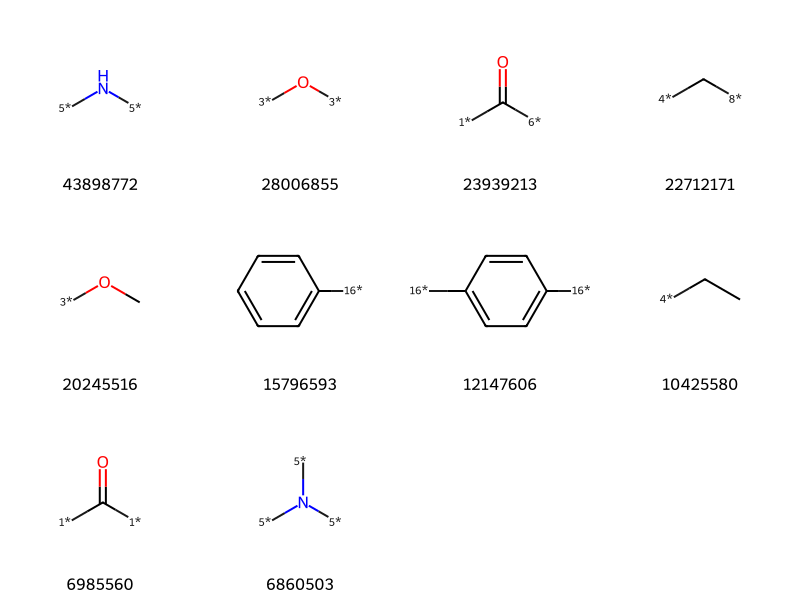

In [17]:
tc,ts = zip(*itms[:10])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

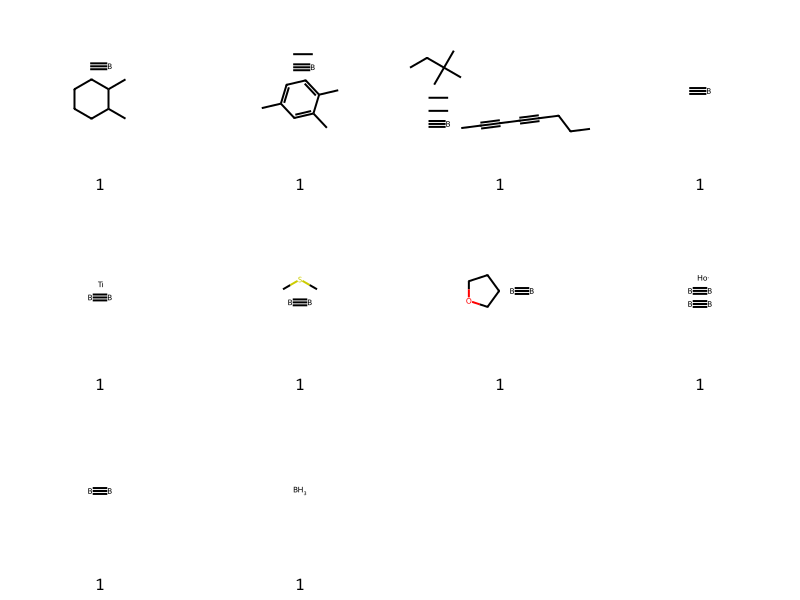

In [18]:
tc,ts = zip(*itms[-10:])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Ew... those aren't particularly nice. Good thing we won't be doing much with them.

Look at the number of times each frequency appears:

In [20]:
import math
def summarize(pts,maxCount=1e7):
    bins=[0]*int(math.ceil(math.log10(maxCount)))
    for cnt,smi in itms:
        if cnt>maxCount:
            bins[-1]+=1
        else:
            bins[int(math.floor(math.log10(cnt)))]+=1
    return bins
bins=summarize(itms)

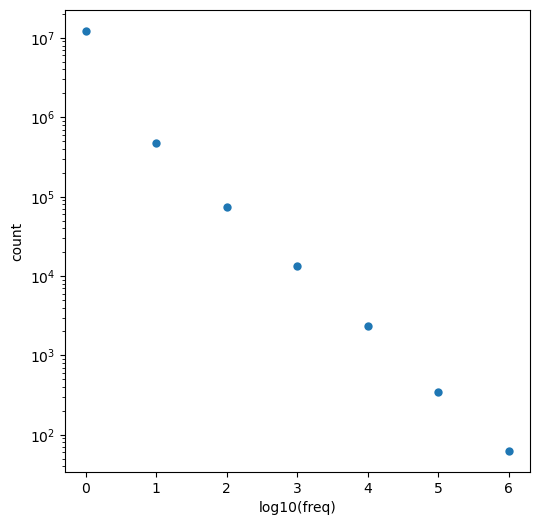

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(list(range(len(bins))),bins,lw=0)
plt.yscale('log')
plt.xlabel('log10(freq)')
plt.ylabel('count');

[The wikipedia says](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) I'm not supposed to call that a power-law distribution, so I'll go with "power-law-like". Is that a thing?

Let's clean up the data a little bit: remove molecules without attachment points and then get rid of the isomeric markers that describe what type of bond was broken:

In [24]:
import re
expr = re.compile(r'[0-9]+\*')
clean_counts = defaultdict(int)
nRejected=0
for k,v in all_counts.items():
    if k.find('*')<0:
        nRejected +=1
        continue
    k = expr.sub('*',k)
    clean_counts[k]+=v

In [25]:
clean_itms = sorted([(v,k) for k,v in clean_counts.items()],reverse=True)
print(len(clean_itms))
clean_itms[:10]

7489755


[(43898772, '[*]N[*]'),
 (32071817, '[*]C[*]'),
 (31711137, '[*]C([*])=O'),
 (28006855, '[*]O[*]'),
 (20245516, '[*]OC'),
 (15883682, '[*]CC'),
 (15796593, '[*]c1ccccc1'),
 (12147606, '[*]c1ccc([*])cc1'),
 (11640436, '[*]C(=O)C[*]'),
 (9657106, '[*]CC[*]')]

Most frequent fragments:

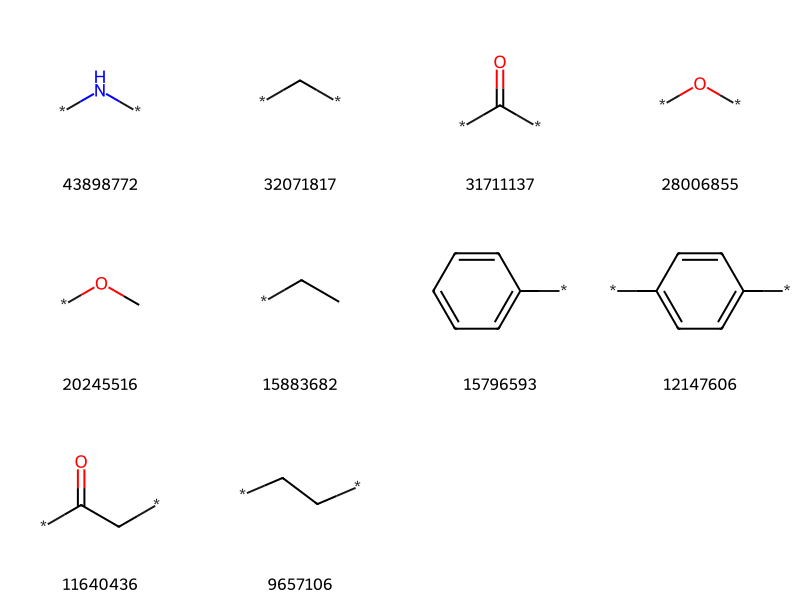

In [26]:
tc,ts = zip(*clean_itms[:10])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Least frequent:

In [27]:
clean_itms[-10:]

[(1, '[*]/C(=[O+]/[H])C(C)CCC([*])=O'),
 (1, '[*]/C(=[O+]/[H])C(C)CC(C)C'),
 (1, '[*]/C(=[O+]/[H])C(C)CC(C)(C)C'),
 (1, '[*]/C(=[O+]/[H])C(C)C/C([*])=[O+]/[H]'),
 (1, '[*]/C(=[O+]/[H])C(C)C(C)C'),
 (1, '[*]/C(=[O+]/[H])C(C)/C([*])=[O+]/[H]'),
 (1, '[*]/C(=[O+]/[H])C(C)(CC(C)(C)C)C(C)(C)C'),
 (1, '[*]/C(=[O+]/[H])C(C)(C)C(C)(N)N'),
 (1, '[*]/C(=[O+]/[H])C(C(C)=O)C(F)F'),
 (1, '[*]/C(=[O+]/[H])C(=C)C(F)(F)F')]

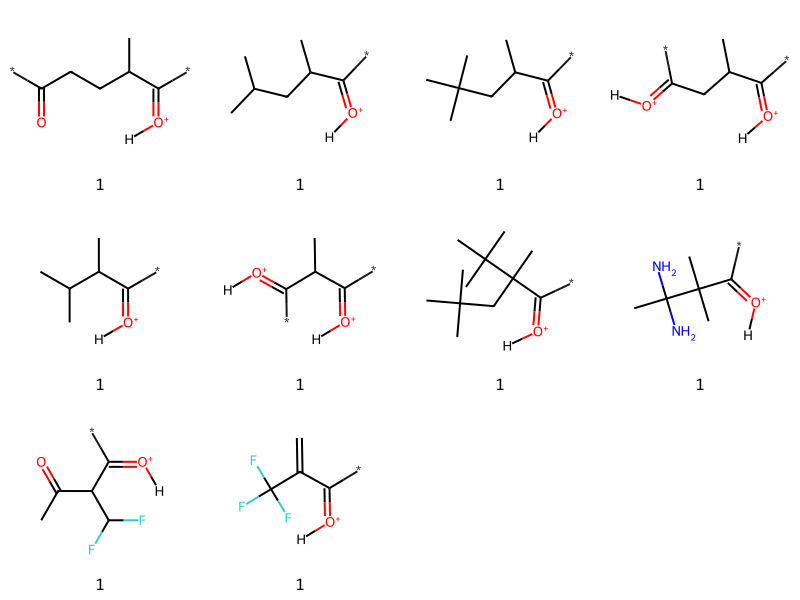

In [28]:
tc,ts = zip(*clean_itms[-10:])
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

Ok, so what about the 1000 most common BRICS fragments?

In [66]:
thousand = clean_itms[:1000]

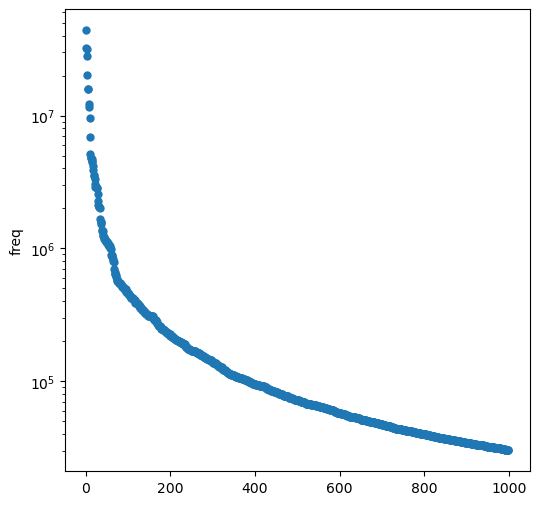

In [67]:
plt.figure(figsize=(6,6))

plt.scatter(range(1000),[x[0] for x in thousand],lw=0)
plt.yscale('log')
plt.ylabel('freq');

That's a steep drop off, but even the least common "word" appears >30000 times in our dataset:

In [68]:
thousand[-1]

(30196, '[*]c1cc(Br)c([*])c(Br)c1')

How many attachment points do those fragments have?

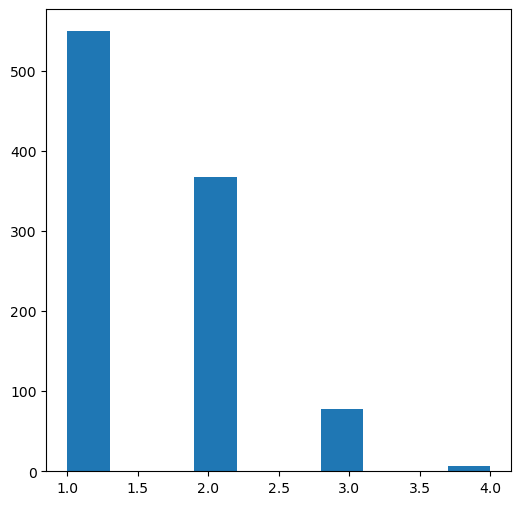

In [69]:
plt.figure(figsize=(6,6))
plt.hist([y.count('*') for x,y in thousand]);

Who's got 4?

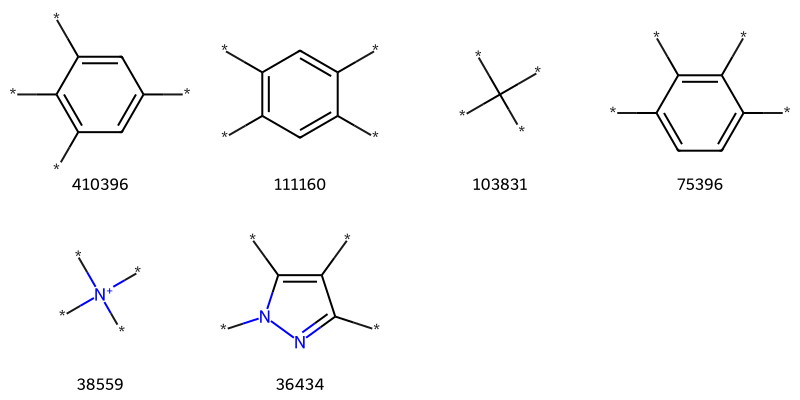

In [70]:
tmp = [x for x in thousand if x[1].count('*')==4]
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts],molsPerRow=4,legends=[str(x) for x in tc])

What about 3?

78 examples


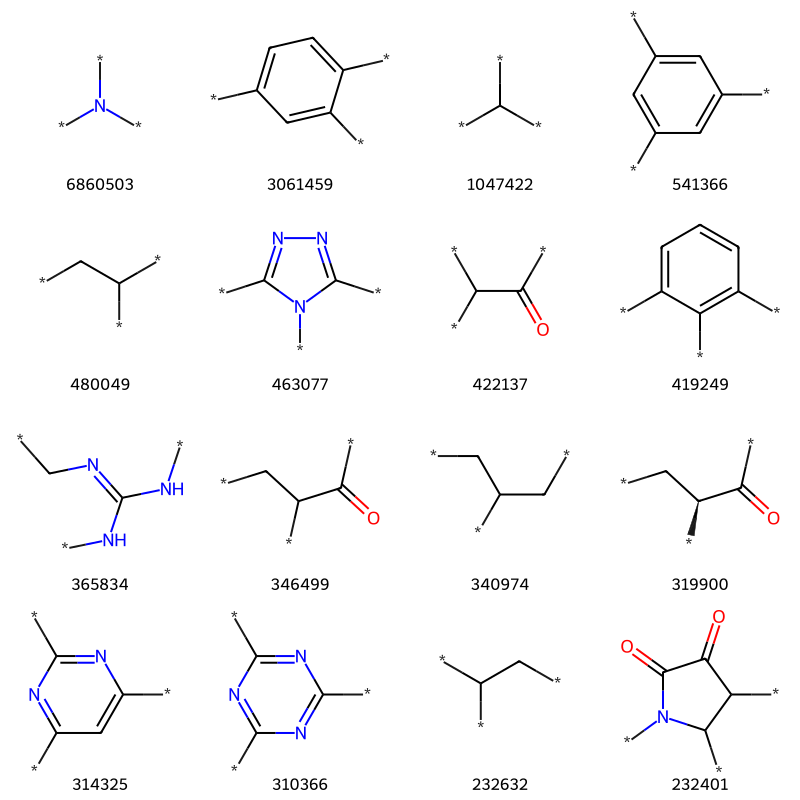

In [72]:
tmp = [x for x in thousand if x[1].count('*')==3]
print(f'{len(tmp)} examples')
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts][:16],molsPerRow=4,legends=[str(x) for x in tc])

There are some examples in there that look like duplicates. That's just happening because the removal of the isotopic labels has made some stereocenters look like they are no longer stereocenters when the SMILES is processed:

In [37]:
[[x for x in thousand if x[1].count('*')==3][i] for i in (4,14)]

[(480049, '[*]CC([*])[*]'), (232632, '[*]C([*])C[*]')]

This is an inherent problem with the simple string-manipulation approach to removing the isotopes from the fragments. Let's fix that problem by actually re-building the molecules. This will remove stereochemistry that is no longer present when the isotope labels are removed from the dummies.

We've got more than 7 million of these, so this next cell takes a while to run:

In [62]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

clean_counts2 = defaultdict(int)
nRejected=0
fails = []
for k,v in all_counts.items():
    if k.find('*')<0:
        nRejected +=1
        continue
    tmol = Chem.MolFromSmiles(expr.sub('*',k))
    if tmol is None:
        fails.append((k,v))
        continue
    k = Chem.MolToSmiles(tmol)
    clean_counts2[k]+=v

In [63]:
import pickle,gzip
with gzip.open('../data/chemical_words_clean_pubchem_counts2.pkl','wb+') as outf:
    pickle.dump(clean_counts2,outf)

In [73]:
clean_itms2 = sorted([(v,k) for k,v in clean_counts2.items()],reverse=True)
print(len(clean_itms2),len(clean_itms))
thousand = clean_itms2[:1000]

7377524 7489755


So we did remove a few.

Let's look at what's left:

75 examples


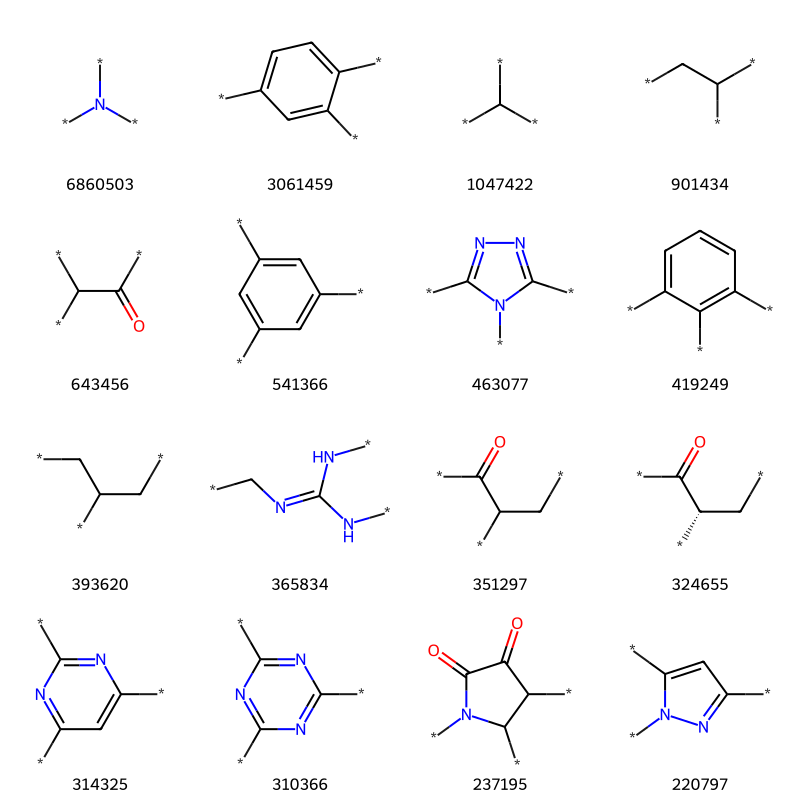

In [74]:
tmp = [x for x in thousand if x[1].count('*')==3]
print(f'{len(tmp)} examples')
tc,ts = zip(*tmp)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in ts][:16],molsPerRow=4,legends=[str(x) for x in tc])

Write out our thousand common chemical words, this file will be in the github repo:

In [45]:
outf=open('../data/thousand_words.pubchem.no_iso.smi','w+')
for tc,ts in thousand:
    print(ts,tc,file=outf)

I'm going to want to use the ones that are still isotopically labeled later, so write those out too. This file will also be in the github repo:

In [46]:
t_itms = [(v,k) for k,v in all_counts.items()]
iso_itms = sorted([(v,k) for v,k in t_itms if k.count('*')>0],reverse=True)
print(len(iso_itms))
thousand_iso = iso_itms[:1000]
outf=open('../data/thousand_words.pubchem.iso.smi','w+')
for tc,ts in thousand_iso:
    print(ts,tc,file=outf)

7838372


As a teaser, let's make some new molecules:

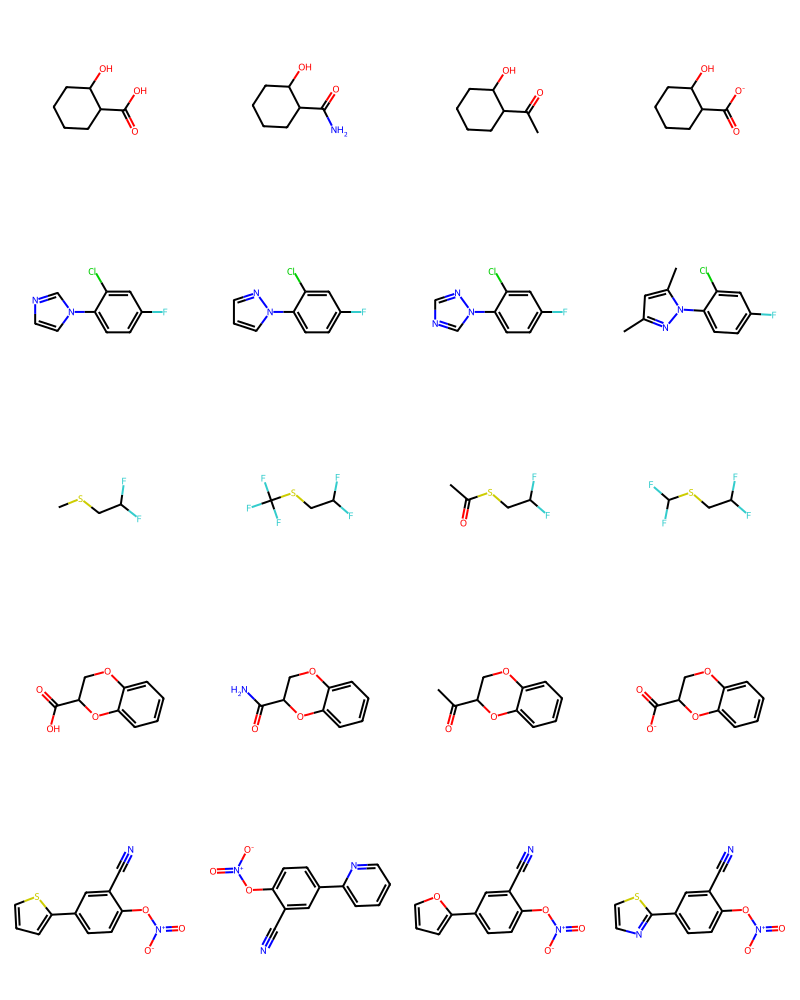

In [60]:
import random
thousand_iso_frags = [Chem.MolFromSmiles(y) for x,y in thousand_iso]
new_mols = []
# the building algorithm tends to explore around a given point, 
# so let's pick a number of starting points and enumerate a few molecules
# around each of them:
for i in range(5):
    random.seed(0x12367+i)
    brics_gen = BRICS.BRICSBuild(thousand_iso_frags)
    for tm in [next(brics_gen) for x in range(4)]:
        try:
            Chem.SanitizeMol(tm)
        except:
            continue
        new_mols.append(tm)
Draw.MolsToGridImage(new_mols,molsPerRow=4)

That's enough for now...